In [ ]:
!pip install torch torchvision transformers matplotlib openai tqdm scikit-learn gdown

In [ ]:
import os
import random
from PIL import Image

real_image_dir = "/content/drive/MyDrive/real_vs_fake_dataset/0_real"
fake_image_dir = "/content/drive/MyDrive/real_vs_fake_dataset/1_fake"

def load_images(image_dir):
  image_paths = [
      os.path.join(image_dir, img) for img in os.listdir(image_dir)
      if img.endswith(('.png', '.jpg', '.jpeg'))
  ]

  images = [Image.open(img_path).convert("RGB") for img_path in image_paths]
  return images

real_images = load_images(real_image_dir)
fake_images = load_images(fake_image_dir)

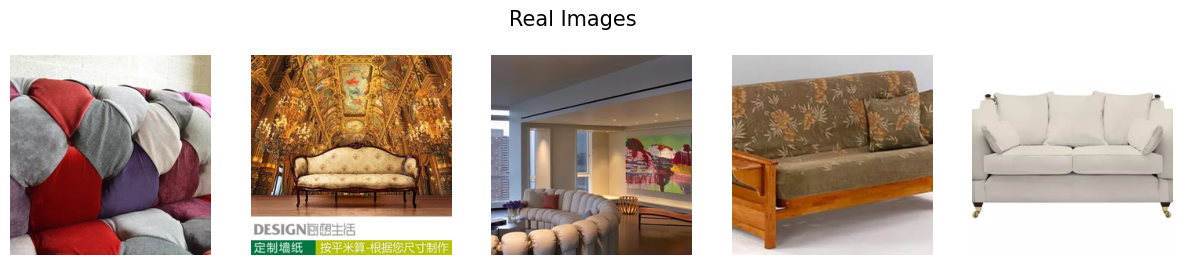

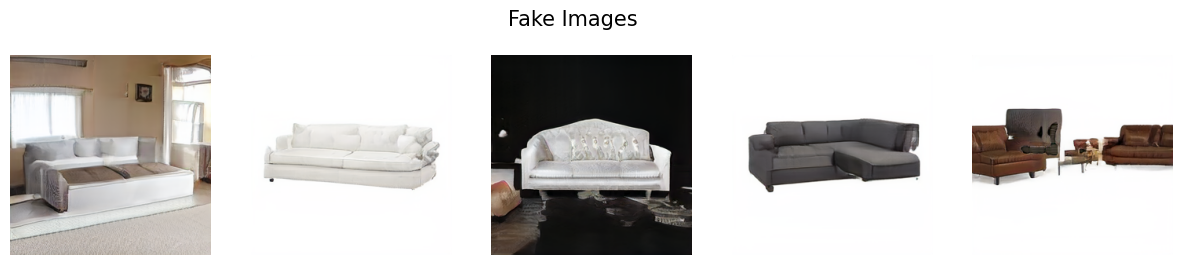

In [ ]:
import matplotlib.pyplot as plt

def visualize_images(images, title, num_images = 5):
  plt.figure(figsize=(15,3))
  for i, img in enumerate(images[:num_images]):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis('off')
  plt.suptitle(title, fontsize=15)
  plt.show()

visualize_images(real_images, "Real Images")
visualize_images(fake_images, "Fake Images")

In [ ]:
from transformers import CLIPProcessor
from transformers import CLIPModel
import torch
import tqdm
import numpy as np

device = "cuda" if torch .cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def extract_features(images, model, processor):
  features = []

  for img in tqdm.tqdm(images, desc="Ectracting features"):
    inputs = processor(images=img, return_tensors="pt").to(device)

    with torch.no_grad():
      feature = model.get_image_features(**inputs)

    features.append(feature.cpu().numpy().flatten())
  return np.array(features)

real_features = extract_features(real_images, model, processor)
fake_features = extract_features(fake_images, model, processor)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]


Ectracting features: 100%|██████████| 100/100 [00:02<00:00, 35.27it/s]


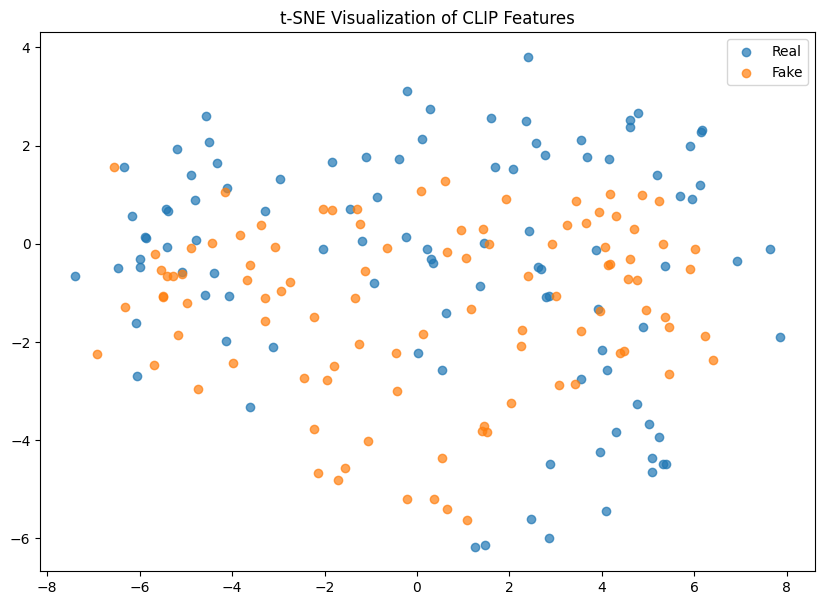

In [ ]:
from sklearn.manifold import TSNE

features = np.vstack((real_features, fake_features))
labels = np.array([0] * len(real_features) + [1] * len(fake_features))

tsne = TSNE(n_components=2, perplexity=50, random_state=42)
tsne_results = tsne.fit_transform(features)

def plot_tsne(tsne_results, labels):
  plt.figure(figsize=(10,7))
  plt.scatter(tsne_results[labels == 0, 0],
              tsne_results[labels == 0, 1],
              label = "Real", alpha = 0.7)
  plt.scatter(tsne_results[labels == 1, 0],
              tsne_results[labels == 1, 1],
              label = "Fake", alpha = 0.7)
  plt.legend()
  plt.title("t-SNE Visualization of CLIP Features")
  plt.show()
plot_tsne(tsne_results, labels)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

real_labels = np.zeros(len(real_features))
fake_labels = np.ones(len(fake_features))

X = np.vstack((real_features, fake_features))
y = np.concatenate((real_labels, fake_labels))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy a the model : {accuracy:.2f}")

accuracy a the model : 0.85


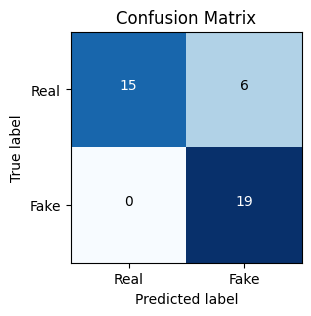

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (4,3))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Real', 'Fake'])
plt.yticks(tick_marks, ['Real', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.grid(False)

for i, j in np.ndindex(cm.shape):
  plt.text(j, i, cm[i, j],
           horizontalalignment='center',
           color='white' if cm[i,j] > cm.max() / 2 else 'black')